In [1]:
#import gdown
#gdown.download_folder('https://drive.google.com/drive/folders/1fBs3klrABIbNxvReGZ96lLdOnLTRYEZ5?usp=sharing')

In [2]:
#!curl --remote-name https://raw.githubusercontent.com/aymanmostafa11/Taxi-Ride-Fare-Prediction/main/helpers.py

In [3]:
import sys

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn import linear_model
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from helpers import Model , PreProcessing

import warnings
warnings.filterwarnings("ignore")

In [4]:
RANDOM_STATE = 42

In [5]:
dataPath = 'classification'

In [6]:
taxiRides = pd.read_csv('taxi/taxi-rides-classification.csv')
weather = pd.read_csv('taxi/weather.csv')

#taxiRides = pd.read_csv(dataPath+'/taxi-rides-classification.csv')
#weather = pd.read_csv(dataPath + '/weather.csv')

# taxiRides = pd.read_csv('‪classification‬‏/taxi-rides-classification.csv')
# weather = pd.read_csv('‪classification‬‏/weather.csv')

In [7]:
print(f"Taxi Rides has {taxiRides.shape[0]} Rows and {taxiRides.shape[1]} Columns")
taxiRides.head()

Taxi Rides has 554456 Rows and 10 Columns


,distance,cab_type,time_stamp,destination,source,surge_multiplier,id,product_id,name,RideCategory
0,0.62,Uber,1.544770e+12,West End,Haymarket Square,1.0,c1b4a572-24b2-484d-aac5-b4f97b790480,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,unknown
1,2.27,Uber,1.543400e+12,Boston University,Beacon Hill,1.0,f9e7e7e6-b309-479b-9f90-bf26a1870c81,997acbb5-e102-41e1-b155-9df7de0a73f2,UberPool,cheap
2,2.00,Lyft,1.544920e+12,Back Bay,Haymarket Square,1.0,154e8438-46f5-4e5f-9872-15cc95e85eed,lyft,Lyft,moderate
3,3.98,Lyft,1.543620e+12,Financial District,Northeastern University,1.0,6bdc30a6-9a80-487b-914e-8d9b82ee4acb,lyft_plus,Lyft XL,expensive
4,1.49,Lyft,1.543580e+12,Back Bay,Northeastern University,1.0,0cb12fe9-cd72-4feb-b341-4a566b2e6643,lyft,Lyft,cheap


In [8]:
print(f"Weather has {weather.shape[0]} Rows and {weather.shape[1]} Columns")
weather.head()

Weather has 6276 Rows and 8 Columns


,temp,location,clouds,pressure,rain,time_stamp,humidity,wind
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49


# Data Cleaning

## Taxi Rides

In [9]:
taxiRides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554456 entries, 0 to 554455
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   distance          554456 non-null  float64
 1   cab_type          554456 non-null  object 
 2   time_stamp        554456 non-null  float64
 3   destination       554456 non-null  object 
 4   source            554456 non-null  object 
 5   surge_multiplier  554456 non-null  float64
 6   id                554456 non-null  object 
 7   product_id        554456 non-null  object 
 8   name              554456 non-null  object 
 9   RideCategory      554456 non-null  object 
dtypes: float64(3), object(7)
memory usage: 42.3+ MB


## Null

In [10]:
print("Null Values in columns")
taxiRides.isnull().sum()

Null Values in columns


distance            0
cab_type            0
time_stamp          0
destination         0
source              0
surge_multiplier    0
id                  0
product_id          0
name                0
RideCategory        0
dtype: int64

## product_id and name

In [11]:
print(f"Value counts of 'product_id' feature\n")
taxiRides['product_id'].value_counts()

Value counts of 'product_id' feature



55c66225-fbe7-4fd5-9072-eab1ece5e23e    44204
8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a    44135
997acbb5-e102-41e1-b155-9df7de0a73f2    44108
6d318bcc-22a3-4af6-bddd-b409bfce1546    44038
9a0e7b09-b92b-4c41-9779-2ad22b4d779d    44024
6f72dfc5-27f1-42e8-84db-ccc7a75f6969    43983
6c84fd89-3f11-4782-9b50-97c468b19529    43977
lyft_plus                               41142
lyft_lux                                41041
lyft                                    41015
lyft_luxsuv                             40979
lyft_premier                            40969
lyft_line                               40841
Name: product_id, dtype: int64

In [12]:
print(f"Value counts of 'name' feature\n")
taxiRides['name'].value_counts()

Value counts of 'name' feature



UberX           44204
Taxi            44135
UberPool        44108
Black SUV       44038
WAV             44024
UberXL          43983
Black           43977
Lyft XL         41142
Lux Black       41041
Lyft            41015
Lux Black XL    40979
Lux             40969
Shared          40841
Name: name, dtype: int64

product_id and name represent the same feature so we can drop one of them

## Encoding Timestamps to date

In [13]:
weatherDate = pd.to_datetime(weather['time_stamp'], unit='s').apply(lambda x: x.strftime(('%Y-%m-%d')))
taxiRidesDate = pd.to_datetime(taxiRides['time_stamp'], unit='ms').apply(lambda x: x.strftime(('%Y-%m-%d')))
weather['date'] = weatherDate
taxiRides['date'] = taxiRidesDate

In [14]:
taxiRides.head()

,distance,cab_type,time_stamp,destination,source,surge_multiplier,id,product_id,name,RideCategory,date
0,0.62,Uber,1.544770e+12,West End,Haymarket Square,1.0,c1b4a572-24b2-484d-aac5-b4f97b790480,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,unknown,2018-12-14
1,2.27,Uber,1.543400e+12,Boston University,Beacon Hill,1.0,f9e7e7e6-b309-479b-9f90-bf26a1870c81,997acbb5-e102-41e1-b155-9df7de0a73f2,UberPool,cheap,2018-11-28
2,2.00,Lyft,1.544920e+12,Back Bay,Haymarket Square,1.0,154e8438-46f5-4e5f-9872-15cc95e85eed,lyft,Lyft,moderate,2018-12-16
3,3.98,Lyft,1.543620e+12,Financial District,Northeastern University,1.0,6bdc30a6-9a80-487b-914e-8d9b82ee4acb,lyft_plus,Lyft XL,expensive,2018-11-30
4,1.49,Lyft,1.543580e+12,Back Bay,Northeastern University,1.0,0cb12fe9-cd72-4feb-b341-4a566b2e6643,lyft,Lyft,cheap,2018-11-30


In [15]:
weather.head()

,temp,location,clouds,pressure,rain,time_stamp,humidity,wind,date
0,42.42,Back Bay,1.0,1012.14,0.1228,1545003901,0.77,11.25,2018-12-16
1,42.43,Beacon Hill,1.0,1012.15,0.1846,1545003901,0.76,11.32,2018-12-16
2,42.50,Boston University,1.0,1012.15,0.1089,1545003901,0.76,11.07,2018-12-16
3,42.11,Fenway,1.0,1012.13,0.0969,1545003901,0.77,11.09,2018-12-16
4,43.13,Financial District,1.0,1012.14,0.1786,1545003901,0.75,11.49,2018-12-16


## Joining Dataframes based on date

In [16]:
taxiRides.drop(['time_stamp'],axis = 1, inplace = True)
weather.drop(['time_stamp'],axis = 1, inplace = True)

mergedData = pd.merge(taxiRides,weather.drop_duplicates(subset=['date', 'location']), how = 'left', left_on=['date', 'source'], right_on=['date', 'location'])

In [17]:
mergedData.isnull().sum()

distance                 0
cab_type                 0
destination              0
source                   0
surge_multiplier         0
id                       0
product_id               0
name                     0
RideCategory             0
date                     0
temp                     0
location                 0
clouds                   0
pressure                 0
rain                480515
humidity                 0
wind                     0
dtype: int64

## Rain Feature

Rows with null rain value statistics


,temp,clouds,pressure,rain,humidity,wind
count,5382.000000,5382.000000,5382.00000,0.0,5382.000000,5382.000000
mean,38.461557,0.633618,1008.92490,NaN,0.747293,6.375199
std,6.169892,0.312919,13.46695,NaN,0.124451,3.542713
min,19.620000,0.000000,988.25000,NaN,0.450000,0.290000
25%,35.022500,0.400000,997.39000,NaN,0.660000,3.190000
50%,39.360000,0.680000,1009.56000,NaN,0.730000,6.210000
75%,41.470000,0.930000,1020.95000,NaN,0.850000,9.627500
max,55.410000,1.000000,1035.12000,NaN,0.990000,18.180000


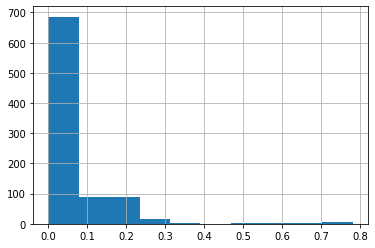

In [18]:
weather['rain'].isnull().sum() / weather['rain'].shape[0]
weather['rain'].hist()
#Does null values of rain revolve around certain values?
print("Rows with null rain value statistics")
weather[weather['rain'].isnull()].describe()



In [19]:
print("Rows with non-null rain value statistics")
weather[weather['rain'].notna()].describe()

Rows with non-null rain value statistics


,temp,clouds,pressure,rain,humidity,wind
count,894.000000,894.000000,894.000000,894.000000,894.000000,894.000000
mean,42.876644,0.943624,1005.557405,0.057652,0.864474,9.377103
std,2.951239,0.146752,7.841618,0.100758,0.093957,3.066719
min,34.100000,0.100000,988.910000,0.000200,0.520000,1.740000
25%,41.482500,0.970000,999.750000,0.004900,0.860000,7.660000
50%,43.820000,1.000000,1005.945000,0.014850,0.900000,9.890000
75%,44.510000,1.000000,1011.237500,0.060925,0.920000,11.187500
max,51.240000,1.000000,1021.790000,0.780700,0.980000,17.160000


In [20]:
weather['rain'].value_counts()

0.0030    85
0.0020    51
0.0040    23
0.0060    17
0.0050    15
          ..
0.0337     1
0.0243     1
0.0367     1
0.0347     1
0.0281     1
Name: rain, Length: 437, dtype: int64

In [21]:
print(f"Values of 0 in the rain feature :{(weather['rain'] == 0).sum()}")
#Rain feature nulls could indicate no rain

Values of 0 in the rain feature :0


In [22]:
weather['rain'].fillna(0,inplace=True)

# Data Visualization

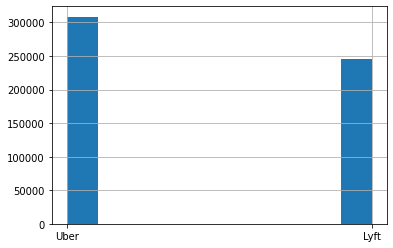

In [23]:
taxiRides['cab_type'].hist()
plt.show()

<AxesSubplot:>

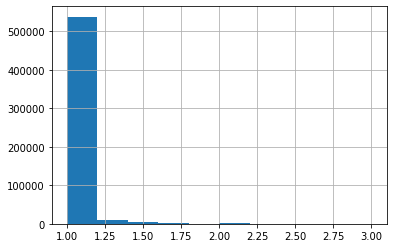

In [24]:
taxiRides['surge_multiplier'].hist()

# Preprocessing

In [25]:
mergedData.head()

,distance,cab_type,destination,source,surge_multiplier,id,product_id,name,RideCategory,date,temp,location,clouds,pressure,rain,humidity,wind
0,0.62,Uber,West End,Haymarket Square,1.0,c1b4a572-24b2-484d-aac5-b4f97b790480,8cf7e821-f0d3-49c6-8eba-e679c0ebcf6a,Taxi,unknown,2018-12-14,27.34,Haymarket Square,0.15,1033.40,NaN,0.81,3.04
1,2.27,Uber,Boston University,Beacon Hill,1.0,f9e7e7e6-b309-479b-9f90-bf26a1870c81,997acbb5-e102-41e1-b155-9df7de0a73f2,UberPool,cheap,2018-11-28,33.67,Beacon Hill,0.12,991.20,NaN,0.82,5.37
2,2.00,Lyft,Back Bay,Haymarket Square,1.0,154e8438-46f5-4e5f-9872-15cc95e85eed,lyft,Lyft,moderate,2018-12-16,42.34,Haymarket Square,1.00,1012.15,0.2068,0.77,11.49
3,3.98,Lyft,Financial District,Northeastern University,1.0,6bdc30a6-9a80-487b-914e-8d9b82ee4acb,lyft_plus,Lyft XL,expensive,2018-11-30,38.46,Northeastern University,0.96,1017.24,NaN,0.66,3.31
4,1.49,Lyft,Back Bay,Northeastern University,1.0,0cb12fe9-cd72-4feb-b341-4a566b2e6643,lyft,Lyft,cheap,2018-11-30,38.46,Northeastern University,0.96,1017.24,NaN,0.66,3.31


In [26]:
preProcessing = PreProcessing()

In [27]:
columnsToDrop = ['id', 'date', 'product_id', 'location']

In [28]:
mergedData.drop(columnsToDrop,axis = 1,inplace=True)

In [29]:
mergedData.head()

,distance,cab_type,destination,source,surge_multiplier,name,RideCategory,temp,clouds,pressure,rain,humidity,wind
0,0.62,Uber,West End,Haymarket Square,1.0,Taxi,unknown,27.34,0.15,1033.40,NaN,0.81,3.04
1,2.27,Uber,Boston University,Beacon Hill,1.0,UberPool,cheap,33.67,0.12,991.20,NaN,0.82,5.37
2,2.00,Lyft,Back Bay,Haymarket Square,1.0,Lyft,moderate,42.34,1.00,1012.15,0.2068,0.77,11.49
3,3.98,Lyft,Financial District,Northeastern University,1.0,Lyft XL,expensive,38.46,0.96,1017.24,NaN,0.66,3.31
4,1.49,Lyft,Back Bay,Northeastern University,1.0,Lyft,cheap,38.46,0.96,1017.24,NaN,0.66,3.31


In [30]:
mergedData.isnull().sum()

distance                 0
cab_type                 0
destination              0
source                   0
surge_multiplier         0
name                     0
RideCategory             0
temp                     0
clouds                   0
pressure                 0
rain                480515
humidity                 0
wind                     0
dtype: int64

## Encoding

###  <i>name</i> Feature

In [31]:
preProcessing.encodeManually(mergedData['name'], PreProcessing.nameFeatureMap)

In [32]:
preProcessing.encodeManually(mergedData['RideCategory'], PreProcessing.labelFeatureMap)

### Other Features

In [33]:
nonIntegerColumns = [col for col in mergedData.columns if mergedData[col].dtypes == object]
print(f"Non Integer Columns : {nonIntegerColumns}")

Non Integer Columns : ['cab_type', 'destination', 'source']


In [34]:
preProcessing.encode(mergedData,nonIntegerColumns)

### Rain Feature Engineering

In [35]:
mergedData['rain'].describe()

count    73941.00000
mean         0.08632
std          0.07043
min          0.00230
25%          0.02990
50%          0.03250
75%          0.14280
max          0.20880
Name: rain, dtype: float64

Referring to google:
<blockquote>Light rainfall is considered <b>less than 0.10 inches</b> of rain per hour. Moderate rainfall measures <b>0.10 to 0.30 inches</b> of rain per hour. Heavy rainfall is more than <b>0.30 inches</b>
 of rain per hour.</blockquote>
0 : no rain <br>
1 : light rain <br>
2 : mid rain <br>
3 : heavy rain (doesn't exist in the data)

In [36]:
mergedData['rainType'] = 0

In [37]:
mergedData['rainType'][(mergedData['rain'] > 0) & (mergedData['rain'] < 0.1)] = 1

In [38]:
mergedData['rainType'][(mergedData['rain'] > 0.1) & (mergedData['rain'] < 0.3)] = 2

In [39]:
mergedData['rainType'].value_counts()

0    480515
1     42966
2     30975
Name: rainType, dtype: int64

## Clouds engineering
making the assumption that clouds are on normalized [Okta Scale](https://polarpedia.eu/en/okta-scale/) that means values less than 0.1 are sunny days

In [40]:
mergedData['sunnyDay'] = 0

In [41]:
mergedData['sunnyDay'][mergedData['clouds'] <= 0.1] = 1

In [42]:
mergedData['sunnyDay'].value_counts()

0    546501
1      7955
Name: sunnyDay, dtype: int64

### Correlation Before PCA

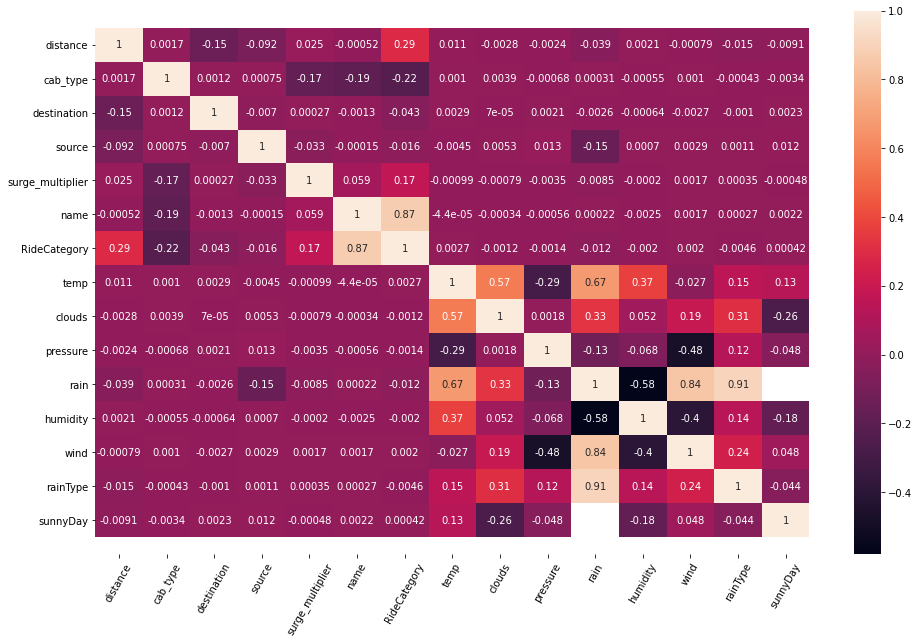

In [43]:
plt.figure(figsize = (16, 10))

ax = sns.heatmap(mergedData.corr(), annot = True)
ax.tick_params(axis = 'x', rotation = 60)
ax.tick_params(axis = 'y', rotation = 0)
# these two lines are meant to fix a bug in matplotlib's current version
# where the graph top and bot rows are cut in half (I copied them from stackoverflow)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

### Dimentionality Reduction

In [44]:
subsetOfData = mergedData[['temp','sunnyDay','rainType','wind','pressure','humidity']]
mergedData.drop(['temp','clouds','sunnyDay','rainType','rain','wind','pressure','humidity'],axis=1,inplace=True)

In [45]:
lowerDimensionWeatherData =preProcessing.reduceDimentionsOf(subsetOfData)
mergedData['weatherState'] = lowerDimensionWeatherData

### Correlation Before PCA

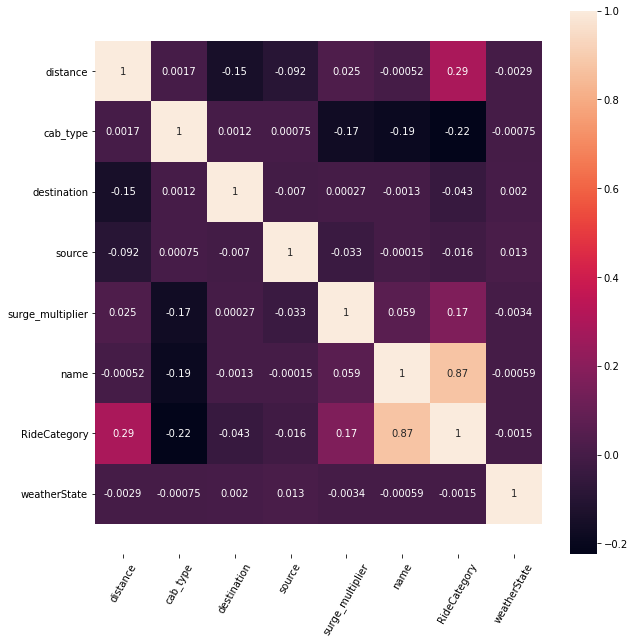

In [46]:
plt.figure(figsize = (10, 10))

ax = sns.heatmap(mergedData.corr(), annot = True)
ax.tick_params(axis = 'x', rotation = 60)
ax.tick_params(axis = 'y', rotation = 0)
# these two lines are meant to fix a bug in matplotlib's current version
# where the graph top and bot rows are cut in half (I copied them from stackoverflow)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.show()

# Model

In [47]:
dataFeatures = mergedData.drop(['RideCategory'],axis=1)
dataLabel = mergedData['RideCategory']

In [48]:
dataFeatures.head()

,distance,cab_type,destination,source,surge_multiplier,name,weatherState
0,0.62,1,11,5,1.0,0,26.134730
1,2.27,1,2,1,1.0,1,-16.492402
2,2.00,0,0,5,1.0,1,2.092880
3,3.98,0,4,8,1.0,2,8.657758
4,1.49,0,0,8,1.0,1,8.657758


In [49]:
model = Model()

In [50]:
preProcessing.scale(dataFeatures)
splitScaledData = model.splitData(dataFeatures,dataLabel)

### Linear Logistic

In [51]:
params = {'solver' : 'lbfgs', 'multi_class' : 'multinomial', 'random_state':RANDOM_STATE}
logisticRegression = model.fitClassificationModel(linear_model.LogisticRegression,
                                                 params,
                                                 evaluationFunction= metrics.f1_score,
                                                 dataDictionary= splitScaledData)

Training Accuracy : 0.8351421666320982
Training f1_score : 0.8351421666320982

Test Accuracy : 0.8340006492803809
Test f1_score : 0.8340006492803809


### Polynomial Logistic

In [52]:
polyDegree = 3

In [53]:
polyFeaturesTrain  = model.changeDegreeOf(splitScaledData['trainFeatures'], polyDegree)
polyFeaturesValidation = model.changeDegreeOf(splitScaledData['testFeatures'], polyDegree)

polyData = splitScaledData.copy()
polyData['trainFeatures'] = polyFeaturesTrain
polyData['testFeatures']  = polyFeaturesValidation

In [54]:
params = {'solver': 'lbfgs', 'multi_class' : 'multinomial', 'random_state' : RANDOM_STATE}
polyModel = model.fitClassificationModel(linear_model.LogisticRegression,
                                         params,
                                         evaluationFunction= metrics.f1_score,
                                         dataDictionary=polyData)

Training Accuracy : 0.8508693221271338
Training f1_score : 0.8508693221271338

Test Accuracy : 0.8504851567290698
Test f1_score : 0.8504851567290698


### Decision Tree

In [55]:
params = {'criterion' : 'entropy', 'random_state' : RANDOM_STATE, 'min_samples_split' : 500}
tree = model.fitClassificationModel(DecisionTreeClassifier,
                                     params,
                                     evaluationFunction= metrics.f1_score,
                                     dataDictionary=splitScaledData)

Training Accuracy : 0.8682151842800588
Training f1_score : 0.8682151842800588

Test Accuracy : 0.864417631569455
Test f1_score : 0.864417631569455


### Random Forest

In [56]:
params = {'n_estimators' : 10, 'random_state' : RANDOM_STATE,'min_samples_split' : 500}
forest = model.fitClassificationModel(RandomForestClassifier,
                                     params,
                                     evaluationFunction= metrics.f1_score,
                                     dataDictionary=splitScaledData)

Training Accuracy : 0.8676538222218214
Training f1_score : 0.8676538222218214

Test Accuracy : 0.8642102225588861
Test f1_score : 0.8642102225588861


### SVM

In [57]:
# params = {'C' : 10, 'random_state' : RANDOM_STATE}
# svm = model.fitClassificationModel(SVC,
#                                     params,
#                                     evaluationFunction= metrics.f1_score,
#                                     dataDictionary=splitScaledData)

### Saving Encoders and Models

In [58]:
from pickle import dump

filename = 'saved_classificationEncoders'
dump(preProcessing.encoders, open(filename, 'wb'))

In [59]:
models = {
    'LogisticRegression':logisticRegression,
    'DecisionTree': tree,
    'RandomForest': forest
}

filename = 'saved_classificationModels'
dump(models, open(filename, 'wb'))

In [60]:
filename = 'saved_classificationScalers'
dump(preProcessing.scalingCache, open(filename, 'wb'))